<a href="https://colab.research.google.com/github/prathamagrawal/Disaster-Tweet-Prediction/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setting up connection between Kaggle and Google Colab
#### I have used kaggle API for Data and Google colab for its better RAM and disk Usage.

In [1]:
!pip install protobuf==3.20.*

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import re
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from string import punctuation
from keras.preprocessing import sequence
from tensorflow import keras
from keras import models
from keras.models import Sequential
from keras import layers
import string
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
from google.colab import files


In [7]:
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

mv: cannot stat 'kaggle.json': No such file or directory


In [8]:
!kaggle competitions download -c nlp-getting-started


nlp-getting-started.zip: Skipping, found more recently modified local copy (use --force to force download)


In [9]:
!!unzip nlp-getting-started.zip

['Archive:  nlp-getting-started.zip',
 'replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: r',
 'new name: train.csv',
 'replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ']

### Data is successfully attached to the google colab notebook location. Now we can read it using the normal ways of reading csv files.

In [10]:
train=pd.read_csv("train.csv")
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [11]:
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [12]:
train['keyword'].unique()

array([nan, 'ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', 'der

In [13]:
train['location'].unique()

array([nan, 'Birmingham', 'Est. September 2012 - Bristol', ...,
       'Vancouver, Canada', 'London ', 'Lincoln'], dtype=object)

In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


<AxesSubplot:>

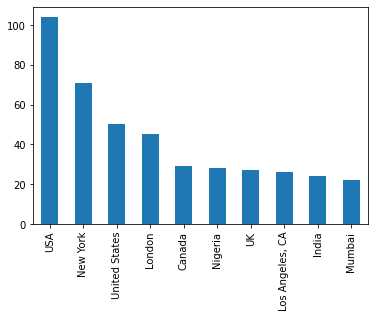

In [15]:
train.location.value_counts()[:10].plot(kind = 'bar')


In [17]:
# Class balance
import plotly.express as px
fig = px.pie(train, names = 'target', title = 'Target Distribution')
fig.update_traces(rotation=90, pull = [0.1], textinfo = "percent+label")
fig.show()

In [18]:
train.drop(['id','keyword','location'],axis=1,inplace=True)

In [19]:
# string.punctuation will give the punctuations.
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [20]:
def clean_text(text):
    clean_text = [char for char in text if char not in string.punctuation]
    clean_text = ''.join(clean_text)
    return clean_text 

In [21]:
train['clean_text'] = train['text'].apply(clean_text)

In [22]:
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

In [23]:
# Remove all URLs, replace by URL
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'URL',text)

# Remove HTML beacon
def remove_HTML(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

# Remove non printable characters
def remove_not_ASCII(text):
    text = ''.join([word for word in text if word in string.printable])
    return text

# Change an abbreviation by its true meaning
def word_abbrev(word):
    return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word

# Replace all abbreviations
def replace_abbrev(text):
    string = ""
    for word in text.split():
        string += word_abbrev(word) + " "        
    return string

# Remove @ and mention, replace by USER
def remove_mention(text):
    at=re.compile(r'@\S+')
    return at.sub(r'USER',text)

# Remove numbers, replace it by NUMBER
def remove_number(text):
    num = re.compile(r'[-+]?[.\d]*[\d]+[:,.\d]*')
    return num.sub(r'NUMBER', text)

# Remove all emojis, replace by EMOJI
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'EMOJI', text)

# Replace some others smileys with SADFACE
def transcription_sad(text):
    eyes = "[8:=;]"
    nose = "['`\-]"
    smiley = re.compile(r'[8:=;][\'\-]?[(\\/]')
    return smiley.sub(r'SADFACE', text)

# Replace some smileys with SMILE
def transcription_smile(text):
    eyes = "[8:=;]"
    nose = "['`\-]"
    smiley = re.compile(r'[8:=;][\'\-]?[)dDp]')
    #smiley = re.compile(r'#{eyes}#{nose}[)d]+|[)d]+#{nose}#{eyes}/i')
    return smiley.sub(r'SMILE', text)

# Replace <3 with HEART
def transcription_heart(text):
    heart = re.compile(r'<3')
    return heart.sub(r'HEART', text)

In [24]:
def clean_tweet(text):
    
    # Remove non text
    text = remove_URL(text)
    text = remove_HTML(text)
    text = remove_not_ASCII(text)
    
    # replace abbreviations, @ and number
    text = replace_abbrev(text)  
    text = remove_mention(text)
    text = remove_number(text)
    
    # Remove emojis / smileys
    text = remove_emoji(text)
    text = transcription_sad(text)
    text = transcription_smile(text)
    text = transcription_heart(text)
  
    return text

In [25]:
train["clean_text"] = train["clean_text"].apply(clean_tweet)

In [26]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [27]:
def remove_stopwords(text):
    remove_stopword = [word for word in text.split() if word.lower() not in stopwords.words('english')]
    return remove_stopword

In [28]:
train["clean_text"] = train["clean_text"].apply(remove_stopwords)

In [29]:
train['length'] = train['clean_text'].apply(len)
train.head()

,text,target,clean_text,length
0,Our Deeds are the Reason of this #earthquake M...,1,"[Deeds, Reason, earthquake, May, ALLAH, Forgiv...",7
1,Forest fire near La Ronge Sask. Canada,1,"[Forest, fire, near, La, Ronge, Sask, Canada]",7
2,All residents asked to 'shelter in place' are ...,1,"[residents, asked, shelter, place, notified, o...",11
3,"13,000 people receive #wildfires evacuation or...",1,"[NUMBER, people, receive, wildfires, evacuatio...",7
4,Just got sent this photo from Ruby #Alaska as ...,1,"[got, sent, photo, Ruby, Alaska, smoke, wildfi...",9


In [30]:
train.shape

(7613, 4)

In [45]:
vocab_size = 23000
tokenizer = Tokenizer(num_words = vocab_size, split='')
tokenizer.fit_on_texts(train['clean_text'].values)
X = tokenizer.texts_to_sequences(train['clean_text'].values)
X = pad_sequences(X)

In [46]:
X

array([[    0,     0,     0, ...,  1434,  4251,    14],
       [    0,     0,     0, ...,  6446,  6447,  1214],
       [    0,     0,     0, ...,   548,  1215,   938],
       ...,
       [    0,     0,     0, ...,   476,  1423,  6412],
       [    0,     0,     0, ...,  5012,  2400,   206],
       [    0,     0,     0, ...,   593,    11, 21503]], dtype=int32)

In [47]:
y=train.target

In [49]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=42)

In [77]:
embed_dim = 32
lstm_out = 32
model = Sequential()
model.add(layers.Embedding(vocab_size,embed_dim,input_length=X.shape[1]))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(units = lstm_out, dropout=0.2, recurrent_dropout=0.4))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [78]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 25, 32)            736000    
                                                                 
 dropout_6 (Dropout)         (None, 25, 32)            0         
                                                                 
 lstm_2 (LSTM)               (None, 32)                8320      
                                                                 
 dropout_7 (Dropout)         (None, 32)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 744,353
Trainable params: 744,353
Non-trainable params: 0
_________________________________________________________________


In [79]:
model.fit(X_train,y_train,epochs=15,batch_size=25,validation_data=(X_test,y_test))

Epoch 1/15
244/244 [==============================] - 13s 39ms/step - loss: 0.5941 - accuracy: 0.6862 - val_loss: 0.4699 - val_accuracy: 0.7899
Epoch 2/15
244/244 [==============================] - 9s 37ms/step - loss: 0.3234 - accuracy: 0.8718 - val_loss: 0.4574 - val_accuracy: 0.7925
Epoch 3/15
244/244 [==============================] - 9s 37ms/step - loss: 0.1784 - accuracy: 0.9343 - val_loss: 0.5454 - val_accuracy: 0.7715
Epoch 4/15
244/244 [==============================] - 9s 37ms/step - loss: 0.0981 - accuracy: 0.9667 - val_loss: 0.6725 - val_accuracy: 0.7479
Epoch 5/15
244/244 [==============================] - 9s 37ms/step - loss: 0.0571 - accuracy: 0.9814 - val_loss: 0.7627 - val_accuracy: 0.7623
Epoch 6/15
244/244 [==============================] - 9s 36ms/step - loss: 0.0399 - accuracy: 0.9875 - val_loss: 0.8155 - val_accuracy: 0.7459
Epoch 7/15
244/244 [==============================] - 9s 36ms/step - loss: 0.0292 - accuracy: 0.9916 - val_loss: 0.8394 - val_accuracy: 0.729

In [80]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, f1_score

In [81]:
print("Accuracy of the model on Training Data is - " , model.evaluate(X_train,y_train)[1]*100 , "%")
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test)[1]*100 , "%")


191/191 [==============================] - 1s 5ms/step - loss: 0.0078 - accuracy: 0.9969
Accuracy of the model on Training Data is -  99.68801140785217 %
48/48 [==============================] - 0s 5ms/step - loss: 1.0975 - accuracy: 0.7354
Accuracy of the model on Testing Data is -  73.53906631469727 %


In [82]:
y_pred = model.predict(X_test).round()


In [83]:
def measure(y_true, y_pred):
    accuracy = round(accuracy_score(y_true, y_pred),4)
    recall = round(recall_score(y_true, y_pred),4)
    precision = round(precision_score(y_true, y_pred),4)
    f1 = round(f1_score(y_true, y_pred),4)
    return pd.Series({'accuracy_score':accuracy,
                     'recall_score':recall,
                     'precision_score':precision,
                     'f1_score':f1})

In [84]:
measure(y_test, y_pred)

accuracy_score     0.7354
recall_score       0.6995
precision_score    0.6858
f1_score           0.6926
dtype: float64

In [85]:
con = confusion_matrix(y_test,y_pred)

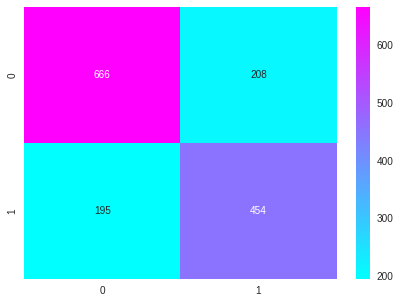

In [86]:
plt.figure(figsize=(7, 5))
sns.heatmap(con, annot=True, fmt='d', cmap='cool')
plt.show()